29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training on clean subset...
Epoch 1/5


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3266 - loss: 1.9739  
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6680 - loss: 1.0943 
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7371 - loss: 0.8306 
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7714 - loss: 0.6988 
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.6314 
Clean test accuracy: 74.00%
Generating adversarial examples with epsilon=0.1 ...
Retraining model with clean + adversarial examples...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4977 - loss: 1.6386 
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6207 - loss: 1.0649
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7201 - loss: 0.8261 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7990 - loss: 0.6588 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8252 - loss: 0.5826 
After adversarial training - clean 

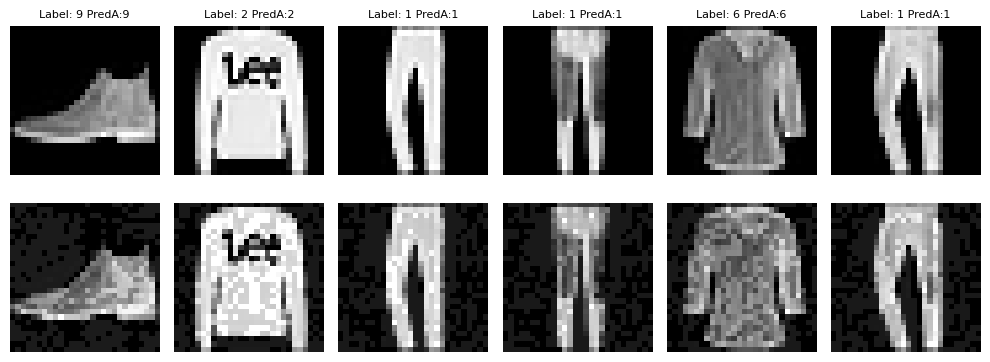

Done. If you want: (1) try different epsilon, (2) use stronger model, (3) visualize perturbations.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# ---------------------------
# Load dataset and subset it
# ---------------------------
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

subset_size = 1000
x_train = x_train[:subset_size].astype("float32") / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200].astype("float32") / 255.0
y_test = y_test[:200]

# ---------------------------
# Model creation
# ---------------------------
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ---------------------------
# FGSM adversarial generator
# ---------------------------
def generate_adversarial_examples(model, x, y, epsilon=0.1):
    """
    Generate adversarial examples for a batch x with labels y using FGSM.
    x: numpy array shape (batch, 28,28), values in [0,1]
    y: numpy array shape (batch,)
    epsilon: perturbation magnitude
    returns: numpy array with same shape as x
    """
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        preds = model(x_tensor)  # shape (batch, n_classes)
        loss_per_example = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, preds)
        loss = tf.reduce_mean(loss_per_example)  # scalar

    gradient = tape.gradient(loss, x_tensor)  # shape (batch, 28,28)
    signed_grad = tf.sign(gradient)
    adv_x = x_tensor + epsilon * signed_grad
    adv_x = tf.clip_by_value(adv_x, 0.0, 1.0)
    return adv_x.numpy()

# ---------------------------
# Train and evaluate flow
# ---------------------------
# 1) Create and train basic model
model = create_model()
print("Training on clean subset...")
model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1)

# Evaluate on clean (small) test set
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Clean test accuracy: {acc * 100:.2f}%")

# 2) Generate adversarial examples from training set (FGSM)
epsilon = 0.1
print(f"Generating adversarial examples with epsilon={epsilon} ...")
adv_x_train = generate_adversarial_examples(model, x_train, y_train, epsilon=epsilon)

# 3) Combine clean + adversarial and retrain (adversarial training)
x_train_combined = np.concatenate([x_train, adv_x_train], axis=0)
y_train_combined = np.concatenate([y_train, y_train], axis=0)

print("Retraining model with clean + adversarial examples...")
model.fit(x_train_combined, y_train_combined, epochs=5, batch_size=64, verbose=1)

# 4) Evaluate on clean test set and also on adversarial test set
loss_clean, acc_clean = model.evaluate(x_test, y_test, verbose=0)
adv_x_test = generate_adversarial_examples(model, x_test, y_test, epsilon=epsilon)
loss_adv, acc_adv = model.evaluate(adv_x_test, y_test, verbose=0)

print(f"After adversarial training - clean test accuracy: {acc_clean * 100:.2f}%")
print(f"After adversarial training - adversarial test accuracy: {acc_adv * 100:.2f}%")

# ---------------------------
# Visualize some examples
# ---------------------------
def show_clean_vs_adversarial(clean_images, adv_images, labels, preds_before=None, preds_after=None, n=6):
    """
    Display n examples of clean vs adv images side-by-side.
    """
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Clean
        plt.subplot(2, n, i+1)
        plt.imshow(clean_images[i], cmap='gray')
        plt.axis('off')
        title = f"Label: {labels[i]}"
        if preds_before is not None:
            title += f"\nPredB:{preds_before[i]}"
        if preds_after is not None:
            title += f" PredA:{preds_after[i]}"
        plt.title(title, fontsize=8)

        # Adversarial
        plt.subplot(2, n, n + i + 1)
        plt.imshow(adv_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# get predictions before/after (optional)
# Here we show predictions by current (already adversarially trained) model
preds_after = np.argmax(model.predict(x_test[:6]), axis=1)
preds_after_adv = np.argmax(model.predict(adv_x_test[:6]), axis=1)

show_clean_vs_adversarial(x_test[:6], adv_x_test[:6], y_test[:6],
                          preds_before=None, preds_after=preds_after)

# End
print("Done. If you want: (1) try different epsilon, (2) use stronger model, (3) visualize perturbations.")
